In [2]:
import torch
import os
import numpy as np
import csv
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import librosa
import librosa.display
import matplotlib.pyplot as plt

In [1]:
import argparse

## Parse

In [3]:
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--lr', default=0.001, type=float, help='learning rate')
    parser.add_argument('--beta1', default=0.9, type=float, help='momentum term for adam')
    parser.add_argument('--batch_size', default=128, type=int, help='batch size')
    parser.add_argument('--log_dir', default='./logs/lp', help='base directory to save logs')
    parser.add_argument('--model_dir', default='', help='base directory to save logs')
    parser.add_argument('--data_root', default='./data/processed_data', help='root directory for data')
    parser.add_argument('--optimizer', default='adam', help='optimizer to train with')
    parser.add_argument('--niter', type=int, default=300, help='number of epochs to train for')
    parser.add_argument('--epoch_size', type=int, default=300, help='epoch size')
    parser.add_argument('--tfr', type=float, default=1.0, help='teacher forcing ratio (0 ~ 1)')
    parser.add_argument('--tfr_start_decay_epoch', type=int, default=50, help='The epoch that teacher forcing ratio become decreasing')
    parser.add_argument('--tfr_decay_step', type=float, default=0.005, help='The decay step size of teacher forcing ratio (0 ~ 1)')
    parser.add_argument('--tfr_lower_bound', type=float, default=0.0, help='The lower bound of teacher forcing ratio for scheduling teacher forcing ratio (0 ~ 1)')
    parser.add_argument('--kl_anneal_cyclical', default=True, action='store_true', help='use cyclical mode')
    parser.add_argument('--kl_anneal_ratio', type=float, default=2, help='The decay ratio of kl annealing')
    parser.add_argument('--kl_anneal_cycle', type=int, default=3, help='The number of cycle for kl annealing (if use cyclical mode)')
    parser.add_argument('--seed', default=1, type=int, help='manual seed')
    parser.add_argument('--n_past', type=int, default=2, help='number of frames to condition on')
    parser.add_argument('--n_future', type=int, default=10, help='number of frames to predict')
    parser.add_argument('--n_eval', type=int, default=12, help='number of frames to predict at eval time')
    parser.add_argument('--rnn_size', type=int, default=256, help='dimensionality of hidden layer')
    parser.add_argument('--prior_rnn_layers', type=int, default=1, help='number of layers')
    parser.add_argument('--posterior_rnn_layers', type=int, default=1, help='number of layers')
    parser.add_argument('--predictor_rnn_layers', type=int, default=2, help='number of layers')
    parser.add_argument('--z_dim', type=int, default=64, help='dimensionality of z_t')
    parser.add_argument('--g_dim', type=int, default=128, help='dimensionality of encoder output vector and decoder input vector')
    parser.add_argument('--c_dim', type=int, default=7, help='dimensionality of encoder output vector and decoder input vector')
    parser.add_argument('--beta', type=float, default=0.0001, help='weighting on KL to prior')
    parser.add_argument('--num_workers', type=int, default=4, help='number of data loading threads')
    parser.add_argument('--last_frame_skip', action='store_true', help='if true, skip connections go between frame t and frame t+t rather than last ground truth frame')
    parser.add_argument('--cuda', default=True, action='store_true') 

    args = parser.parse_args()
    return args

## Dataloader

In [11]:
import torch
import os
import numpy as np
import csv
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import librosa
import librosa.display
import matplotlib.pyplot as plt

default_transform = transforms.Compose([transforms.ToTensor()])

class mimii_dataset(Dataset):
    def __init__(self,mode='train', transform=default_transform):
        assert mode == 'train' or mode == 'test' or mode == 'validate'
        self.root_dir =  './data'
        self.data_type =  'valve'

        if mode=='train':
            self.data_dir = '%s/train/%s' % (self.root_dir, self.data_type)
            self.ordered = False
        elif mode=='validate':
            self.data_dir = '%s/val/%s' % (self.root_dir, self.data_type)
            self.ordered = True
        else:
            self.data_dir = '%s/test/%s' % (self.root_dir, self.data_type)
            self.ordered = True

        self.dirs = []

        for d1 in os.listdir(self.data_dir):
            for d2 in os.listdir('%s/%s' % (self.data_dir, d1)):
                for d3 in os.listdir('%s/%s/%s' % (self.data_dir, d1, d2)):
                    self.dirs.append('%s/%s/%s/%s' % (self.data_dir, d1, d2, d3))

        # print(self.dirs)

        self.transformations = transform


    def __len__(self):
        return len(self.dirs)

    def __getitem__(self, index):
        # print(self.dirs[index])
        y , sr = librosa.load(self.dirs[index], sr=16000)
        M1 = librosa.feature.melspectrogram(y=y, n_fft=512, n_mels=64, sr=sr)
        M_db1 = librosa.power_to_db(M1, ref=np.max)
        image = torch.from_numpy(M_db1)
        image = image[np.newaxis, :] 
        # print(image.shape)
        # print(M_db1.shape)

        # # Show image
        fig = plt.figure()
        plt.gca().xaxis.set_major_locator(plt.NullLocator()) 
        plt.gca().yaxis.set_major_locator(plt.NullLocator()) 
        plt.subplots_adjust(top=1,bottom=0,left=0,right=1,hspace=0,wspace=0) 
        plt.axis('off')
        librosa.display.specshow(M_db1, x_axis='time', y_axis='mel')

        # # Get RGB image array
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        w, h = img.shape[0], img.shape[1]
        img = Image.fromarray(img, mode='RGB')
        # img = img.resize((int(h/2), int(w/2)), Image.ANTIALIAS)
        img = img.resize((64, 64), Image.ANTIALIAS)
        img = self.transformations(img)

        # M_db1_tensor = self.transformations(M_db1)

        return img

torch.Size([1, 3, 64, 64])


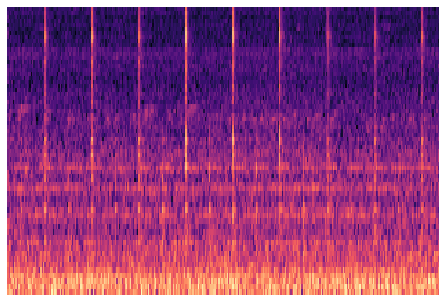

In [12]:

train_dataset = mimii_dataset('train')
val_dataset = mimii_dataset('validate')
train_loader = torch.utils.data.DataLoader(train_dataset,\
                    batch_size=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset,\
                    batch_size=1, shuffle=True)
train_iterator = iter(train_loader)
seq = next(train_iterator)
print(seq.shape)